# Install Libraries

In [61]:
!pip install pennylane pennylane-qiskit

In [62]:
!pip install pennylane scikit-learn numpy pandas

In [63]:
import numpy as np
import pandas as pd
from math import log2, ceil
import pennylane as qml
from pennylane import numpy as pnp
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Loading Dataset

In [64]:
train_df = pd.read_csv('/kaggle/input/random-linear-regression/train.csv')
test_df = pd.read_csv('/kaggle/input/random-linear-regression/test.csv')

# Exploring Dataset

In [65]:
print("Train dataset info:")
print(train_df.info())
print("\nTrain dataset head:")
print(train_df.head())
print("\nTrain dataset description:")
print(train_df.describe())

print("\nTest dataset info:")
print(test_df.info())
print("\nTest dataset head:")
print(test_df.head())

Train dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 0 to 699
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       700 non-null    float64
 1   y       699 non-null    float64
dtypes: float64(2)
memory usage: 11.1 KB
None

Train dataset head:
      x          y
0  24.0  21.549452
1  50.0  47.464463
2  15.0  17.218656
3  38.0  36.586398
4  87.0  87.288984

Train dataset description:
                 x           y
count   700.000000  699.000000
mean     54.985939   49.939869
std     134.681703   29.109217
min       0.000000   -3.839981
25%      25.000000   24.929968
50%      49.000000   48.973020
75%      75.000000   74.929911
max    3530.157369  108.871618

Test dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       300 non-null    int64  
 1   

# Checking & Removing Null/Infinite Values

In [66]:
print("Missing values per column:")
print(train_df.isnull().sum())

print("\nInfinite values per column:")
print((train_df == np.inf).sum() + (train_df== -np.inf).sum())

Missing values per column:
x    0
y    1
dtype: int64

Infinite values per column:
x    0
y    0
dtype: int64


In [67]:
train_df = train_df.dropna(subset=['y'])

In [68]:
print("Missing values per column:")
print(train_df.isnull().sum())

print("\nInfinite values per column:")
print((train_df == np.inf).sum() + (train_df== -np.inf).sum())

Missing values per column:
x    0
y    0
dtype: int64

Infinite values per column:
x    0
y    0
dtype: int64


In [69]:
print("Missing values per column:")
print(test_df.isnull().sum())

print("\nInfinite values per column:")
print((test_df == np.inf).sum() + (test_df== -np.inf).sum())

Missing values per column:
x    0
y    0
dtype: int64

Infinite values per column:
x    0
y    0
dtype: int64


# Checking for outliers

In [70]:
numeric_cols = train_df.select_dtypes(include='number').columns

for col in numeric_cols:
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = train_df[(train_df[col] < Q1 - 1.5 * IQR) | (train_df[col] > Q3 + 1.5 * IQR)]
    
    if len(outliers) > 0:
        print(f"{col}: {len(outliers)} outliers")
    else: 
        print('none')

none
none


In [71]:
numeric_cols = test_df.select_dtypes(include='number').columns

for col in numeric_cols:
    Q1 = test_df[col].quantile(0.25)
    Q3 = test_df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = test_df[(test_df[col] < Q1 - 1.5 * IQR) | (test_df[col] > Q3 + 1.5 * IQR)]
    
    if len(outliers) > 0:
        print(f"{col}: {len(outliers)} outliers")
    else: 
        print('none')

none
none


# Classical Linear Regression

In [72]:
X_train = train_df[["x"]]
y_train = train_df["y"]

X_test = test_df[["x"]]
y_test = test_df["y"]

#Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Train linear regression
model = LinearRegression()
model.fit(X_train_scaled, y_train)

#Predict on test set
y_pred = model.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("R²:", r2)
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)

R²: 0.9888014444327563
MAE: 2.4157718500412595
MSE: 9.43292219203932
RMSE: 3.0713062680298298


In [73]:
np.random.seed(42) #setting a random seed to ensure reproducibility of results.
def load_random_linear_regression_data():

    X_train = train_df['x'].values.reshape(-1, 1)
    y_train = train_df['y'].values
    X_test = test_df['x'].values.reshape(-1, 1)
    y_test = test_df['y'].values
    
    print(f"Train shapes - X: {X_train.shape}, y: {y_train.shape}")
    print(f"Test shapes - X: {X_test.shape}, y: {y_test.shape}")
    
    return X_train, X_test, y_train, y_test

In [74]:
def build_quantum_linear_system(X, y, lam=1e-3):
    d = X.shape[1]
    
    #Ensure d is power of 2 by trimming/padding
    n_qubits_needed = ceil(log2(d))
    target_dim = 2**n_qubits_needed
    
    if target_dim > d:
        #Padding with zeros
        X_padded = np.zeros((X.shape[0], target_dim))
        X_padded[:, :d] = X
        X = X_padded
        d = target_dim
    elif target_dim < d:
        #reduce dimensionality
        X_reduced, _ = reduce_dimensionality(X, n_components=target_dim)
        X = X_reduced
        d = target_dim
    
    #build A and b
    A = X.T @ X + lam * np.eye(d)
    b = X.T @ y
    
    return A, b, d

In [75]:
def reduce_dimensionality(X, n_components=4):
    #PCA=> to reduce dimensionality
    pca = PCA(n_components=n_components)
    X_reduced = pca.fit_transform(X)
    return X_reduced, pca

In [76]:
def create_quantum_cost_function(A, b, n_qubits, n_layers=2):
    #normalize
    b_norm = b / np.linalg.norm(b)
    A_norm = A / np.linalg.norm(A, ord=2)
    
    dev = qml.device("default.qubit", wires=n_qubits)
    
    def ansatz(params):
        params = params.reshape(n_layers, n_qubits, 3)
        for layer in range(n_layers):
            #single-qubit rotations
            for qubit in range(n_qubits):
                qml.Rot(*params[layer, qubit], wires=qubit)
            #entanglement
            for qubit in range(n_qubits - 1):
                qml.CNOT(wires=[qubit, qubit+1])
    
    @qml.qnode(dev, interface="autograd")
    def variational_state(params):
        ansatz(params)
        return qml.state()
    
    def cost(params):
        state = variational_state(params)
        x = np.real(state[:len(b_norm)])
        
        # Compute cost: ||A|x⟩ - |b⟩||²
        Ax = A_norm @ x
        cost_val = np.linalg.norm(Ax - b_norm)**2
        
        return cost_val
    
    return cost, ansatz, variational_state

In [77]:
def run_qlr_on_random_linear_regression(n_qubits=1, n_layers=2, max_iter=50):
    X_train, X_test, y_train, y_test = load_random_linear_regression_data()
    
    #scale data
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()
    
    A, b, d = build_quantum_linear_system(X_train_scaled, y_train_scaled)
    
    print(f"Using {n_qubits} qubits for {d}-dimensional problem")
    
    #creating quantum cost function
    cost_func, ansatz, variational_state = create_quantum_cost_function(
        A, b, n_qubits, n_layers
    )
    
    #optimizing quantum parameters
    n_params = n_layers * n_qubits * 3
    init_params = 0.01 * np.random.randn(n_params)
    
    #callback
    def callback(x):
        if len(callback.costs) % 10 == 0:
            current_cost = cost_func(x)
            print(f"Iteration {len(callback.costs)+1}: Cost = {current_cost:.6f}")
        callback.costs.append(cost_func(x))
    
    callback.costs = []
    
    result = minimize(cost_func,init_params,method="COBYLA",options={"maxiter": max_iter},callback=callback)

    #getting results
    trained_params = result.x
    final_state = variational_state(trained_params)
    beta_quantum = np.real(final_state[:d])
    
    #make predictions
    y_pred_quantum_scaled = X_test_scaled @ beta_quantum
    y_pred_quantum = scaler_y.inverse_transform(y_pred_quantum_scaled.reshape(-1, 1)).flatten()
    
    #classical comparison
    beta_classical = np.linalg.lstsq(X_train_scaled, y_train_scaled, rcond=None)[0]
    y_pred_classical_scaled = X_test_scaled @ beta_classical
    y_pred_classical = scaler_y.inverse_transform(y_pred_classical_scaled.reshape(-1, 1)).flatten()
    
    #metrics
    mse_quantum = mean_squared_error(y_test, y_pred_quantum)
    mse_classical = mean_squared_error(y_test, y_pred_classical)
    
    r2_quantum = r2_score(y_test, y_pred_quantum)
    r2_classical = r2_score(y_test, y_pred_classical)
    
    return {
        "predictions": {"true": y_test,"quantum": y_pred_quantum,"classical": y_pred_classical},
        "metrics": {"mse_quantum": mse_quantum,"mse_classical": mse_classical,"r2_quantum": r2_quantum,"r2_classical": r2_classical},
        "cost_history": callback.costs
    }


In [78]:
def plot_results(results):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    #cost
    ax1.plot(results['cost_history'])
    ax1.set_title('Quantum Cost Function')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Cost')
    ax1.grid(True)
    
    #predictions vs True values
    ax2.scatter(results['predictions']['true'], results['predictions']['quantum'], 
               alpha=0.6, label='Quantum', color='blue')
    ax2.scatter(results['predictions']['true'], results['predictions']['classical'], 
               alpha=0.6, label='Classical', color='red')
    min_val = min(results['predictions']['true'].min(), results['predictions']['quantum'].min(), results['predictions']['classical'].min())
    max_val = max(results['predictions']['true'].max(), results['predictions']['quantum'].max(), results['predictions']['classical'].max())
    ax2.plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect prediction')
    ax2.set_title('Predictions vs True Values')
    ax2.set_xlabel('True Values')
    ax2.set_ylabel('Predictions')
    ax2.legend()
    ax2.grid(True)
    
    #MSE
    metrics = results['metrics']
    ax3.bar(['Quantum', 'Classical'], 
           [metrics['mse_quantum'], metrics['mse_classical']],
           color=['blue', 'red'], alpha=0.7)
    ax3.set_title('Mean Squared Error Comparison')
    ax3.set_ylabel('MSE')
    
    #R^(2)
    ax4.bar(['Quantum', 'Classical'], 
           [metrics['r2_quantum'], metrics['r2_classical']],
           color=['blue', 'red'], alpha=0.7)
    ax4.set_title('R-squared Comparison')
    ax4.set_ylabel('R²')
    
    plt.tight_layout()
    plt.show()
    
    #metrics
    print(f"\nQuantum MSE: {metrics['mse_quantum']:.4f}")
    print(f"Classical MSE: {metrics['mse_classical']:.4f}")
    print(f"Quantum R²: {metrics['r2_quantum']:.4f}")
    print(f"Classical R²: {metrics['r2_classical']:.4f}")

In [79]:
#run QLR
results = run_qlr_on_random_linear_regression(
    n_qubits=1,  #1 feature=1 qubit (2^1 = 2 dimensions)
    n_layers=2,
    max_iter=50
)

Train shapes - X: (699, 1), y: (699,)
Test shapes - X: (300, 1), y: (300,)
Using 1 qubits for 1-dimensional problem
Iteration 1: Cost = 0.015318
Iteration 11: Cost = 0.000005
Iteration 21: Cost = 0.000000
Iteration 31: Cost = 0.000000
Iteration 41: Cost = 0.000000
Iteration 51: Cost = 0.000000


QUANTUM LINEAR REGRESSION!


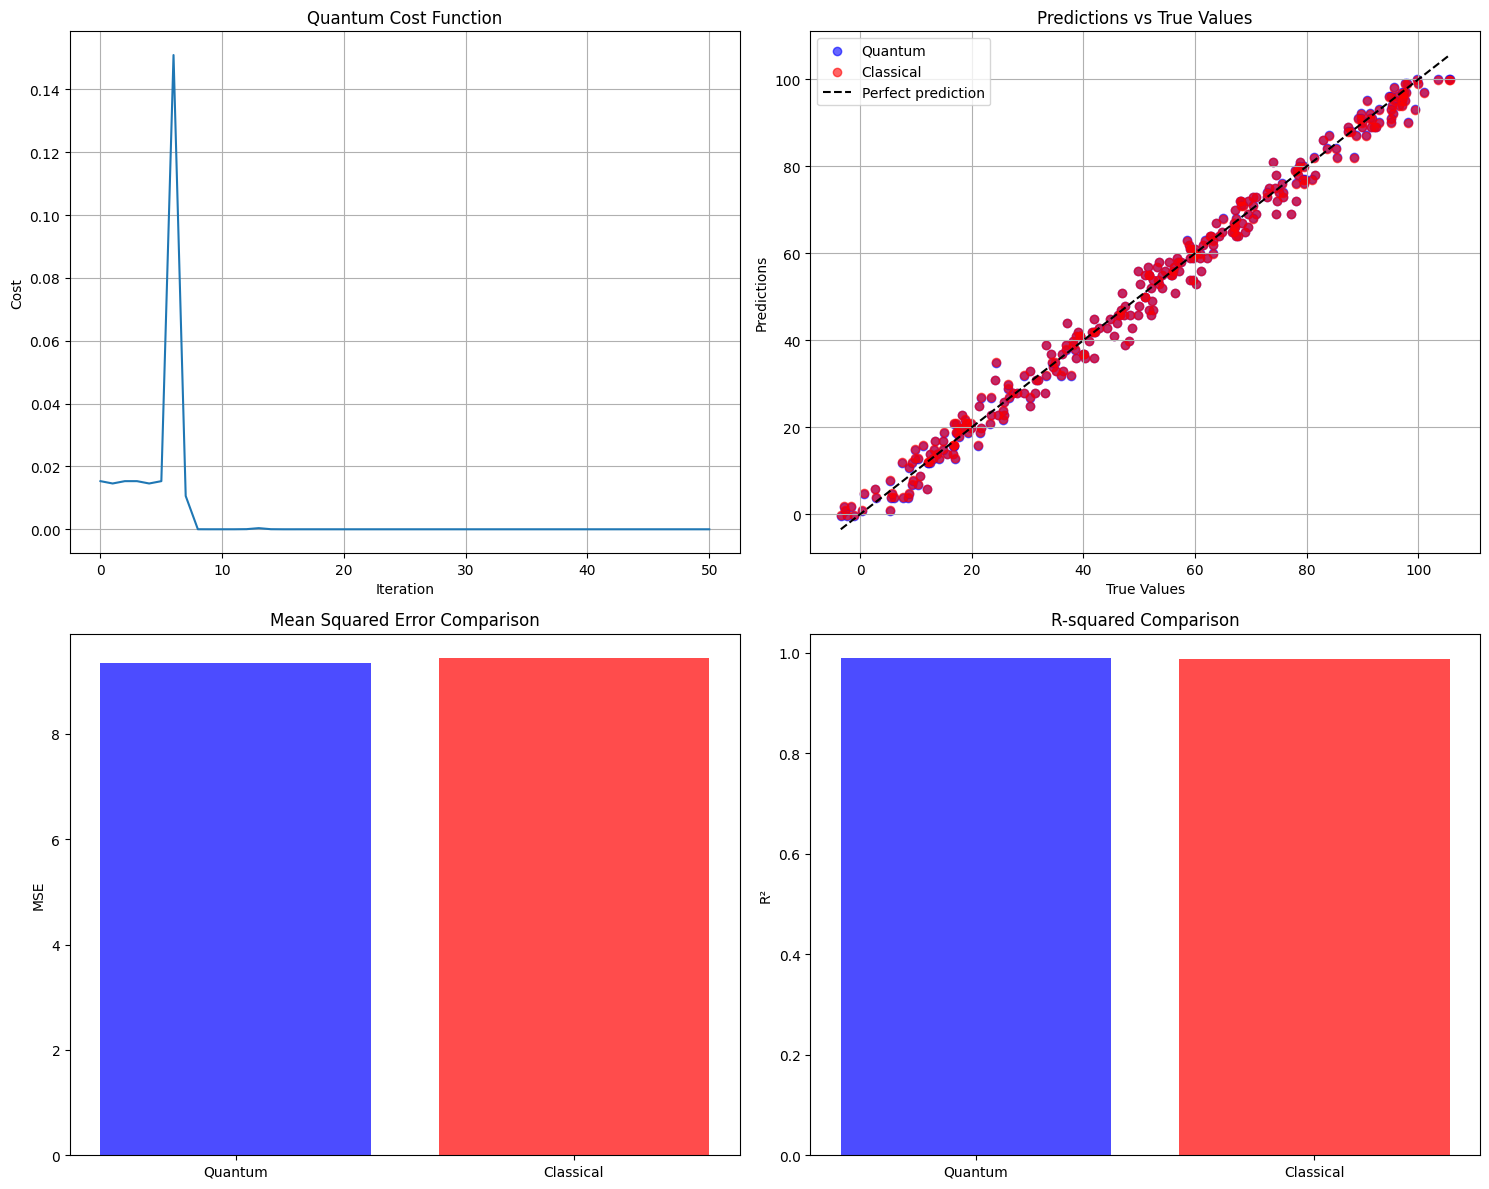


Quantum MSE: 9.3440
Classical MSE: 9.4329
Quantum R²: 0.9889
Classical R²: 0.9888


In [80]:
print("QUANTUM LINEAR REGRESSION!")
plot_results(results)